In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import time

In [2]:
data= pd.read_excel(r"C:\Users\USER\Desktop\stu_cor.xlsx")
df = pd.DataFrame(data)
print(df.info())
print("\n",df.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1374 entries, 0 to 1373
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Student number     1374 non-null   int64 
 1   Student name       1374 non-null   object
 2   Specialization     1374 non-null   object
 3   Course number      1374 non-null   int64 
 4   Course name        1374 non-null   object
 5   Course code        1374 non-null   object
 6   Department number  1374 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 75.3+ KB
None

 Student number       220
Student name         220
Specialization         3
Course number         73
Course name           71
Course code           70
Department number    159
dtype: int64


In [9]:
G = nx.Graph()

# group students by course
course_students= df.groupby("Course number")["Student number"].apply(set).to_dict()

# add nodes
G.add_nodes_from(course_students.keys())

# add edges
courses= list(course_students.keys())
for i in range(len(courses)):
    for j in range(i + 1, len(courses)):
        if course_students[courses[i]] & course_students[courses[j]]:
            G.add_edge(courses[i], courses[j])

print(G)

Graph with 73 nodes and 898 edges


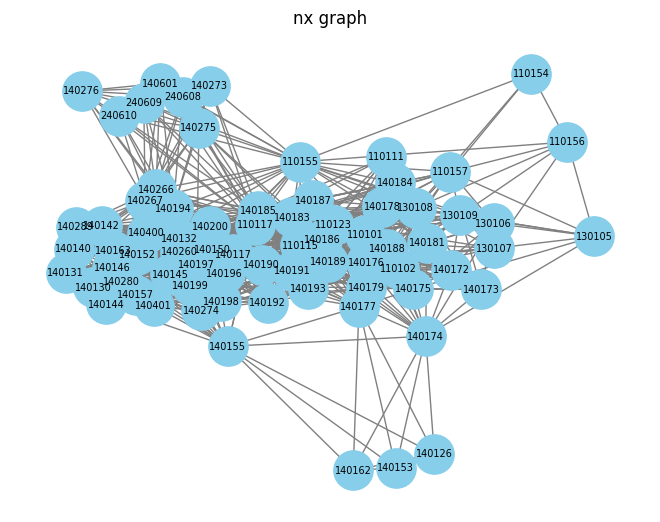

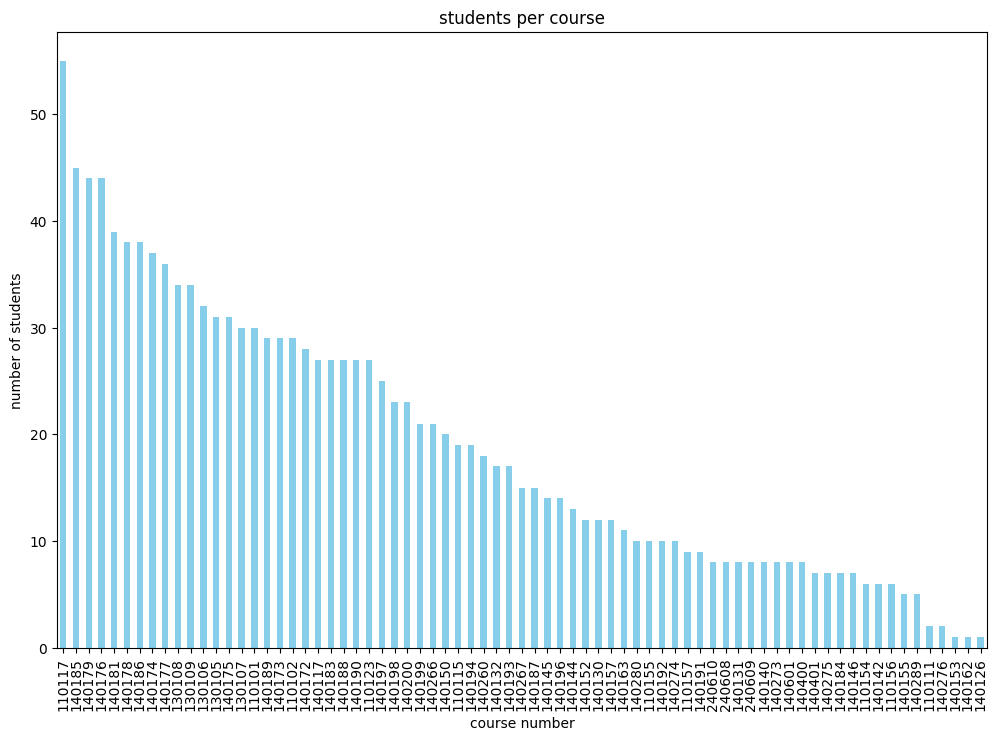

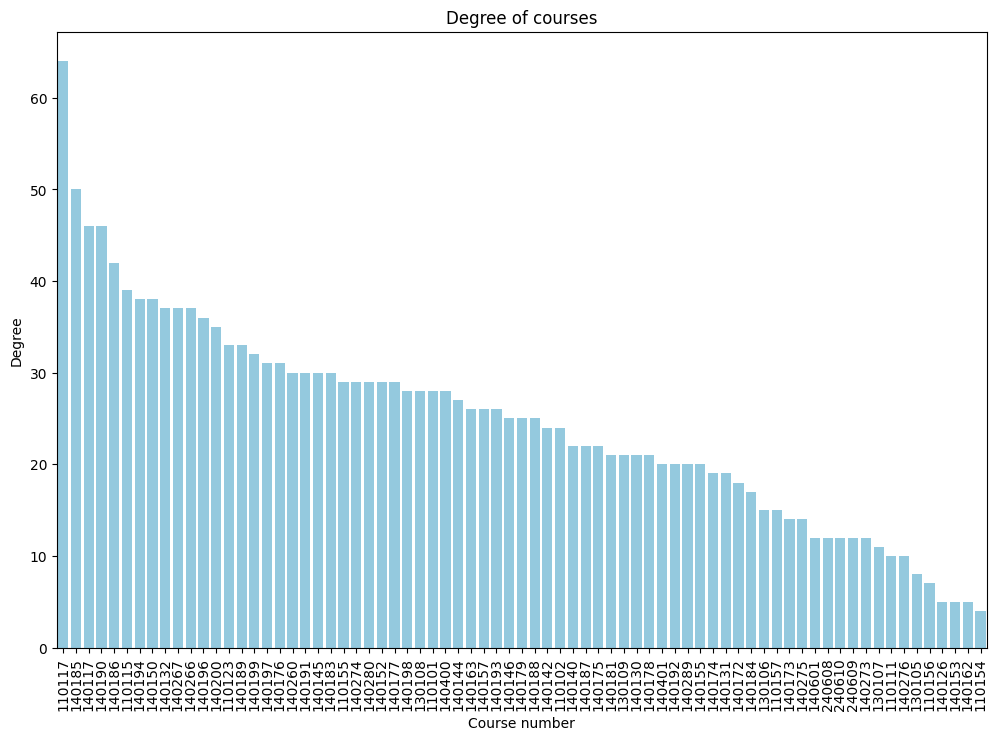

In [4]:
# Visualizations
nx.draw(G, with_labels=True, node_color='skyblue', edge_color='gray', node_size=800, font_size=7)
plt.title("nx graph")
plt.show()


student_counts = df["Course number"].value_counts()
plt.figure(figsize=(12, 8))
student_counts.plot(kind="bar", color="skyblue")
plt.xlabel("course number")
plt.ylabel("number of students")
plt.title("students per course")
plt.xticks(rotation=90)
plt.show()



course_degrees = dict(G.degree())
df_degrees = pd.DataFrame({
    'Course': list(course_degrees.keys()),
    'Degree': list(course_degrees.values())})

df_degrees = df_degrees.sort_values(by='Degree', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(data=df_degrees, x='Course', y='Degree', color='skyblue',order=df_degrees['Course'])
plt.xlabel("Course number")
plt.ylabel("Degree")
plt.title("Degree of courses")
plt.xticks(rotation=90)
plt.show()

In [11]:
# apply Graph Coloring
i=["random_sequential","largest_first","smallest_last","DSATUR","independent_set"]
n=0
while n< len(i):
   start_time= time.time()
   coloring= nx.coloring.greedy_color(G, strategy=i[n])
   num_periods= max(coloring.values()) + 1
   end_time= time.time()
   elapsed_time= end_time - start_time
   print("\nminimum exam periods using "+i[n]+" coloring : " + str(num_periods))
   print("the time it took "+str(elapsed_time))
   n+=1
print()


minimum exam periods using random_sequential coloring : 18
the time it took 0.0009682178497314453

minimum exam periods using largest_first coloring : 17
the time it took 0.0008642673492431641

minimum exam periods using smallest_last coloring : 16
the time it took 0.030890226364135742

minimum exam periods using DSATUR coloring : 16
the time it took 0.032752275466918945

minimum exam periods using independent_set coloring : 19
the time it took 0.04833507537841797



In [12]:
# the table

# coloring
coloring= nx.coloring.greedy_color(G, strategy="smallest_last")
num_periods= max(coloring.values()) + 1

# count students per course
course_counts= df.groupby(["Course number", "Course name"])["Student number"].count().reset_index(name="Number of students")

# define available time slots
time_slots= ["9 AM - 11 AM", "12 PM - 2 PM", "3 PM - 5 PM"]
num_days= int(np.ceil(num_periods/ len(time_slots)))


# map slot number to (day, time)
slot_to_time= {
    slot: ((slot// len(time_slots))+ 1, time_slots[slot % len(time_slots)])
    for slot in range(num_periods)
}

# merge course_counts with coloring info
course_schedule= course_counts.copy()
course_schedule["Slot"]= course_schedule["Course number"].map(coloring)
course_schedule[["Exam day", "Exam time"]]= course_schedule["Slot"].map(slot_to_time).apply(pd.Series)
course_schedule= course_schedule.drop(columns="Slot")

# final schedule
schedule_df = course_schedule.sort_values(by=["Exam day", "Exam time"])
print(schedule_df.head())

    Course number                     Course name  Number of students  \
13         130108                   ريادة الأعمال                  34   
15         140117                  التحرير العربي                  27   
16         140126                  كهرومغناطيسية2                   1   
35         140175                   كيمياء عامة 1                  31   
63         140275  التحويل الكهروميكانيكي للطاقة1                   7   

    Exam day     Exam time  
13         1  12 PM - 2 PM  
15         1  12 PM - 2 PM  
16         1  12 PM - 2 PM  
35         1  12 PM - 2 PM  
63         1  12 PM - 2 PM  


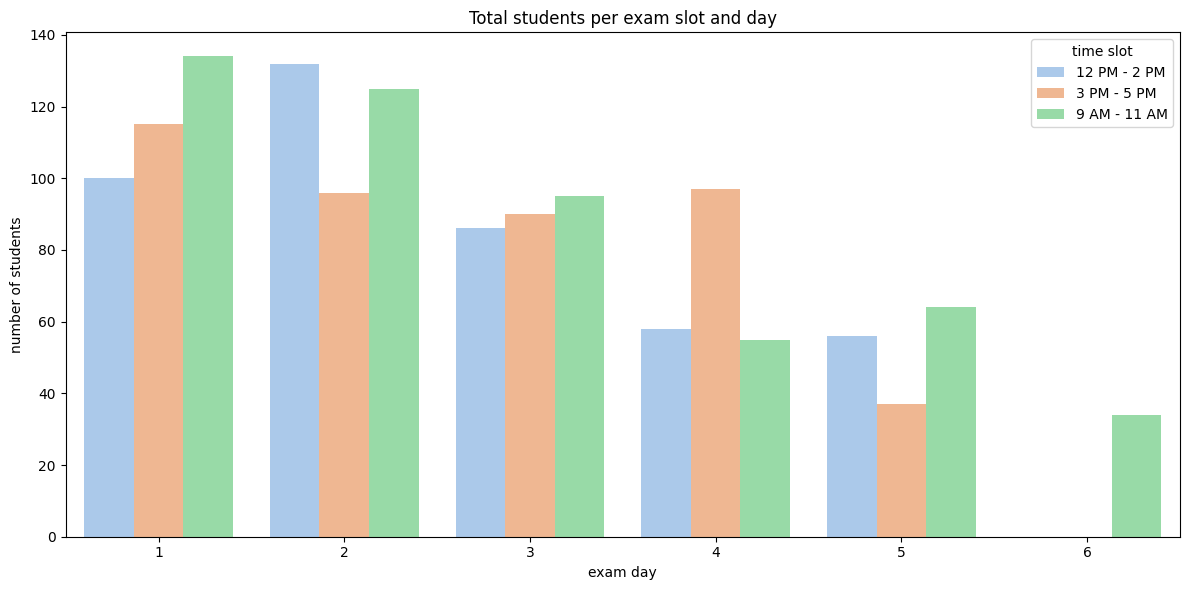

In [7]:
bar_data = course_schedule.groupby(["Exam day", "Exam time"])["Number of students"].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=bar_data, x="Exam day", y="Number of students", hue="Exam time",palette="pastel")
plt.title("Total students per exam slot and day")
plt.xlabel("exam day")
plt.ylabel("number of students")
plt.legend(title="time slot")
plt.tight_layout()
plt.show()

In [8]:
custom_path = r"C:\Users\USER\Desktop\programming\py proj\exam_schedule.xlsx"  # Corrected
schedule_df.to_excel(custom_path, index=False)
print(f"Exam schedule saved at: {custom_path}")

Exam schedule saved at: C:\Users\USER\Desktop\programming\py proj\exam_schedule.xlsx
